## Exploratory Analysis, using Named-Entity Recognition to Classify Police Officers

##### Jonathan Juarez
##### Date 2/13/2024

To understand how police officers are being disciplined when allegations are found to be sustained, Named-Entity Recognition, or NER models, can be utilized to identify and extract relevant entities from text, such as types of disciplinary actions.

In [8]:
import os
import re
import random
import pandas as pd

In [42]:
from pathlib import Path
import os

current_dir = Path(os.path.dirname(os.path.realpath("__file__")))
project_root = current_dir.parent.parent

# Define the path to the text_files directory
text_files_dir = project_root / "text_files"

I'm stealing both Matt's and Fede's cleaning of the text as it might be important to follow similar cleaning structures. We should use common cleaning functions by storing them in a .py file later on.

In [9]:
PATH = text_files_dir
CHARS_TO_REMOVE = ["\n"]
REGEX_PATTERNS = [
    r"civilian office of police accountability\s+",
    r"log\s*\#\s*\d+",
    r"-\s*\d+\s*\d+",
    r"summary report of investigation\s+",
    r"i.\s+executive\s+summary",
    r"_+",
    r"\s*date of incident:\s*\w+\s+\d+,\s+\d+",
    r"\s*time of incident:\s*\d+:\d+\w+",
    r"\s*location of incident:\s*\d+\w+\s*\w+",
    r"\s*date of copa notification:\s*\w+\s+\d+,\s+\d+",
    r"\s*time of copa notification:\s*\d+:\d+\w+",
    r"applicable rules and laws|"
    r"conclusion|"
    r"digital evidence|"
    r"documentary evidence|"
    r"legal standard|",
]


I'm using Fede's TextParser to format the text and turn them into lists of strings.

In [10]:
class TextParser:
    CHARS_TO_REMOVE = CHARS_TO_REMOVE
    REGEX_PATTERNS = REGEX_PATTERNS

    def __init__(self, path):
        self.path = path

    def txt_to_list(self, filename):
        """
        Add each line of a text file to a list
        """

        file_path = os.path.join(self.path, filename)
        lines = []
        with open(file_path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip().split()
                lines.append(line)

        return lines

    def file_to_string(self, filename):
        """
        Add each line of a text file to a string
        """
        text = ""
        file_path = os.path.join(self.path, filename)
        with open(file_path, "r", encoding="utf-8") as f:
            for line in f:
                for char in self.CHARS_TO_REMOVE:
                    line = line.replace(char, "")
                text += line

        text = text.strip()
        #text = text.lower() #NET requires words to be capitilized for proper usage
        text = re.sub(r"\s+", " ", text)

        # Remove REGEX patterns
        for pattern in self.REGEX_PATTERNS:
            text = re.sub(pattern, "", text, flags=re.IGNORECASE)
        return text

text_parser = TextParser(PATH)


In [11]:
# Create a list of the txt files for processing NER later
cases = os.listdir(PATH)
cases = [case for case in cases if case.endswith(".txt")]
cases = random.sample(cases, 10)

I'll be using the NLTK library for the NER model. There are packages in the NLTK that must be downloaded in order to run the code below.

In [12]:
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk

nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/jonathanjuarez/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/jonathanjuarez/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jonathanjuarez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jonathanjuarez/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

The [ne_chunk](https://www.nltk.org/api/nltk.chunk.html) function takes the part-of-speech tagged words and performs NER. It groups consecutive tokens into chunks and labels them based on their entity type (e.g., PERSON, ORGANIZATION, LOCATION). The extract_entities function then iterates through the resulting tree structure and identifies entities. These entities are returned as list of tuples, where each tuple contains the identified entity and its corresponding entity type.

In [13]:
def extract_entities(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    tree = ne_chunk(pos_tags)

    entities = []
    for subtree in tree:
        if isinstance(subtree, nltk.Tree):
            entity = " ".join([word for word, tag in subtree.leaves()])
            entity_type = subtree.label()
            entities.append((entity, entity_type))
    
    return entities


In [14]:
for case in cases:
    case_text = text_parser.file_to_string(case)
    list_of_entities = extract_entities(case_text)

    # Print or store the information for each case
    print(f"Entities for Case:", case)
    for entity, entity_type in list_of_entities:
        print(f"Word: {entity}, POS Tag: {pos_tag([entity])[0][1]}, Entity Type: {entity_type}")

    # If we want to store the information in a different format do it here

Entities for Case: 1091250.txt
Word: Incident, POS Tag: NN, Entity Type: GPE
Word: Ashland Avenue AM, POS Tag: NN, Entity Type: PERSON
Word: Officer A, POS Tag: NN, Entity Type: PERSON
Word: PPO, POS Tag: NN, Entity Type: ORGANIZATION
Word: District, POS Tag: NNP, Entity Type: GPE
Word: Beat, POS Tag: NN, Entity Type: PERSON
Word: XXXX, POS Tag: NN, Entity Type: ORGANIZATION
Word: Citgo Gas, POS Tag: NN, Entity Type: ORGANIZATION
Word: Ashland Avenue, POS Tag: NN, Entity Type: PERSON
Word: PPO, POS Tag: NN, Entity Type: ORGANIZATION
Word: INVOLVED, POS Tag: NN, Entity Type: ORGANIZATION
Word: PARTIES Involved, POS Tag: VBN, Entity Type: ORGANIZATION
Word: Star, POS Tag: NN, Entity Type: PERSON
Word: XXXX, POS Tag: NN, Entity Type: ORGANIZATION
Word: Employee ID, POS Tag: NN, Entity Type: PERSON
Word: XXXX, POS Tag: NN, Entity Type: ORGANIZATION
Word: DOA, POS Tag: NN, Entity Type: ORGANIZATION
Word: Rank, POS Tag: NN, Entity Type: PERSON
Word: Unit, POS Tag: NN, Entity Type: ORGANIZATI

We may want to focus only on named people in the cases and avoid printing or storing information for every word, so created a new function extract_persons for this specific purpose. 

In [15]:
def extract_persons(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    tree = ne_chunk(pos_tags)

    persons = []
    for subtree in tree:
        if isinstance(subtree, nltk.Tree) and subtree.label() == 'PERSON':
            persons.append(" ".join([word for word, tag in subtree.leaves()]))

    return persons

for case in cases:
    case_text = text_parser.file_to_string(case)
    list_of_persons = extract_persons(case_text)

    # Print or store the information for each case
    print(f"Persons in Case:", case)
    for person in list_of_persons:
        print(person)


Persons in Case: 1091250.txt
Ashland Avenue AM
Officer A
Beat
Ashland Avenue
Star
Employee ID
Rank
Star
Employee ID
Rank
Ashland Ave.
Officer A
Involved Individual
Rule
Ashland Ave.
Officer
Involved Individual
Rule
Ashland Ave.
Involved Individual
Ashland Ave.
Involved Individual
Rule
Illinois Traffic Pedestrian Stop Statistical Study Federal
Involved Individual
Involved Individual
Body Worn Camera
Involved Individual
Hey
Involved Individual
Involved Individual
Stop Report No
Chrysler
Audio
Involved Individual
Involved Individual
Involved Individual
Involved Individual
Officer A
Involved Individual
Involved Individual
Involve
Terry v. Ohio
Chapte
Municipal Code
People v. Jackson
Smith
Garcia
Traffic Stop Statistical Study
Mott
Ashland Ave.
Officer A
Involved Individual
Ashland Ave.
Officer
Involved Individual
Ashland Ave.
Involved Individual
Ashland Ave.
Involved Individual
Rule
Persons in Case: 1045804.txt
Wallace Street
Normal Avenue
Wallace Street
Wallace Street
Officer
Wallace Stre

To better determine people extraction, I updated the function to return a set of unique person entities found and their counts in the text, and modified the function to allow different entity extractions, such as "PERSON", "LOCATION", etc.

In [16]:
from nltk.tree import Tree

In [17]:
def extract_entity(text, entity_type, counts=False):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    tree = ne_chunk(pos_tags)

    entities = set()  # Use a set to store unique entities
    entity_counts = {}  # Initialize a dictionary to count occurrences of each entity

    for subtree in tree:
        if isinstance(subtree, Tree) and subtree.label() == entity_type:
            entity_name = " ".join([word for word, tag in subtree.leaves()])
            entities.add(entity_name)  # Add to set to ensure uniqueness
            
            # Count occurrences if counts is True
            if counts:
                if entity_name in entity_counts:
                    entity_counts[entity_name] += 1
                else:
                    entity_counts[entity_name] = 1

    if counts:
        return entity_counts
    else:
        return list(entities)

Here I aim to analyze what entities labeled as "PERSON" are extracted.

In [18]:
all_unique_entities = set()
all_entity_counts = {} 

for case in cases:
    case_text = text_parser.file_to_string(case)
    unique_entities = extract_entity(case_text, 'PERSON')  # Extract unique entities from this case
    # Update the overall set with new entities from this case
    all_unique_entities.update(unique_entities)

    entity_counts = extract_entity(case_text, 'PERSON', counts=True)  # Extract entity counts from this case
    # Update the overall dictionary with counts from this case
    for entity, count in entity_counts.items():
        if entity in all_entity_counts:
            all_entity_counts[entity] += count  # Add to existing count
        else:
            all_entity_counts[entity] = count  # Initialize count for new entities

In [19]:
print("Counts of Each Person Name:")
for person, count in sorted(all_entity_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{person}: {count}")

Counts of Each Person Name:
Officer: 284
Wallace Street: 63
Farias: 39
Retired CPD Sergeant: 37
Officer A: 22
Star: 22
Richardson: 22
Mukite: 21
Involved Individual: 19
Officer Richardson: 19
Officer Mukite: 18
Mr.: 14
Officer Perez: 12
Officer Trujillo: 12
Officer Farias: 12
Officer Nunez: 11
Trujillo: 10
David: 9
Murillo: 9
Ashland Ave.: 8
Nunez: 8
Alexander David: 7
Officer Zachary Richardson: 7
Officer David: 7
Officer Victor Perez: 7
Yanez: 7
Rank: 6
Officer Roger Farias: 6
Retired CPD Sergeant A: 6
Terry v. Ohio: 5
Avery: 5
Farm Mutual Automobile Insurance: 5
People v. Coan: 5
Officer Alexander David: 5
Further: 5
Officer Murillo: 5
Arnulfo Yanez: 5
Officer Yanez: 5
Beat XXX: 5
Employee ID: 4
Rule: 4
Officer Officer: 4
Laboratory Report: 4
Wesson: 4
Battery Report: 4
Male: 4
Terry: 4
Harrison Street: 4
Order: 4
Ryan Trujillo: 4
Officer Ryan Trujillo: 4
Unit Detailed: 3
Unit DOB: 3
Again: 3
Illinois: 3
Gender: 3
Race: 3
Millard Ave.: 3
Employee: 3
Fourth Amendment: 3
Andrea Kerste

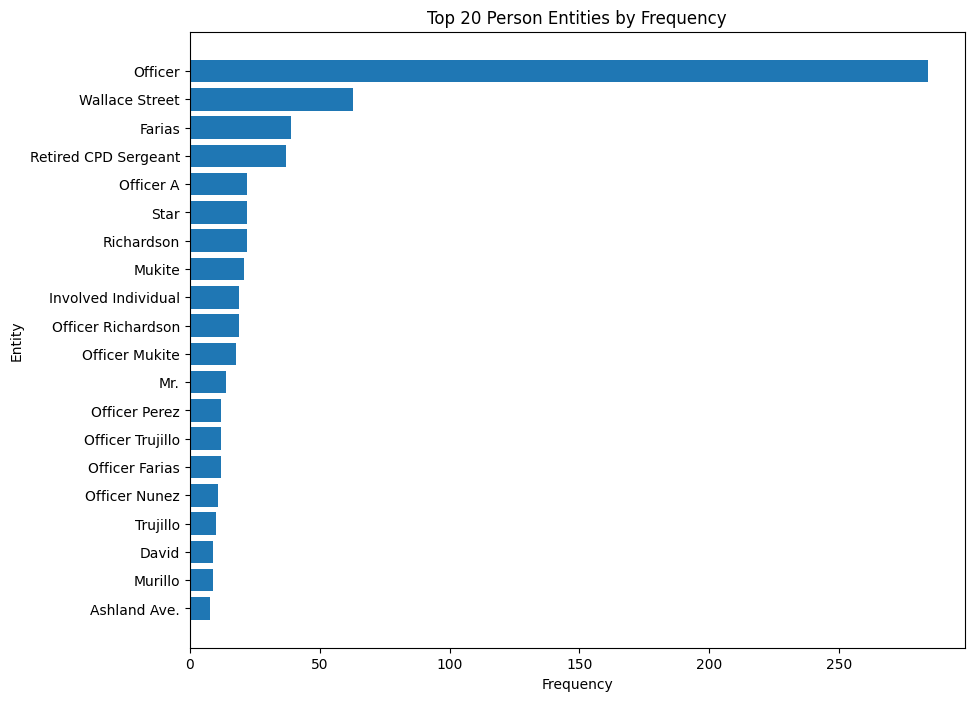

In [20]:
import matplotlib.pyplot as plt

# Prepare data for plotting
names = list(all_entity_counts.keys())
counts = list(all_entity_counts.values())

# Sort data by counts
sorted_indices = sorted(range(len(counts)), key=lambda k: counts[k], reverse=True)
sorted_names = [names[i] for i in sorted_indices]
sorted_counts = [counts[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(10, 8))
plt.barh(sorted_names[:20], sorted_counts[:20])  # Display top 20 entities for readability
plt.xlabel('Frequency')
plt.ylabel('Entity')
plt.title('Top 20 Person Entities by Frequency')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest counts at the top
plt.show()

Top occurring person entitites appear to be fine, however those that are low in frequency are being misclassified. I suspect this is due to NLTKs relyance on capitalization for classification. I attempt to see what happens if all text is lower-cased below.

In [21]:
all_unique_entities = set()
all_entity_counts = {} 

for case in cases:
    case_text = text_parser.file_to_string(case)
    case_text = case_text.lower()  # Convert the entire text to lowercase
    unique_entities = extract_entity(case_text, 'PERSON')  # Extract unique entities from this case
    # Update the overall set with new entities from this case
    all_unique_entities.update(unique_entities)

    entity_counts = extract_entity(case_text, 'PERSON', counts=True)  # Extract entity counts from this case
    # Update the overall dictionary with counts from this case
    for entity, count in entity_counts.items():
        if entity in all_entity_counts:
            all_entity_counts[entity] += count  # Add to existing count
        else:
            all_entity_counts[entity] = count  # Initialize count for new entities

In [22]:
print("Counts of Each Person Name, with lower cased text:")
for person, count in sorted(all_entity_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{person}: {count}")

Counts of Each Person Name, with lower cased text:
mr.: 6


This shows capitilizing is a parameter to consider when conducting NER with NLTK. The out of the box NER model using NLTK doesn't appear to be that great in capturing relevant people and consideres locations and other random entitites as a "Person". We will try [SpaCy](https://spacy.io/api), which has a more accurate NER model compared to NLTK and we will fine-tune parameters if needed.

In [23]:
import spacy

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

def extract_entity_spacy(text, entity_type, counts=False):
    doc = nlp(text)
    entities = set()
    entity_counts = {}

    for ent in doc.ents:
        if ent.label_ == entity_type:
            entity_name = ent.text
            entities.add(entity_name)

            if counts:
                entity_counts[entity_name] = entity_counts.get(entity_name, 0) + 1

    return entity_counts if counts else list(entities)


In [24]:
all_persons = set()
all_person_counts = {}

for case in cases:
    case_text = text_parser.file_to_string(case)  # Assuming this function reads case file content
    case_text = case_text.lower()
    persons = extract_entity_spacy(case_text, 'PERSON')
    person_counts = extract_entity_spacy(case_text, 'PERSON', counts=True)
    
    # Update the set with unique person names
    all_persons.update(persons)
    
    # Update the dictionary with counts
    for person, count in person_counts.items():
        all_person_counts[person] = all_person_counts.get(person, 0) + count



In [25]:
print("Person Entity Counts:")
for person, count in sorted(all_person_counts.items(), key=lambda item: item[1], reverse=True):
    print(f"{person}: {count}")


Person Entity Counts:
richardson: 38
david: 17
zachary richardson: 13
alexander david: 10
roger farias: 10
victor perez: 9
perez: 9
carla jackson: 8
a.: 6
jackson: 6
terry v. ohio: 5
avery v. state farm mutual automobile insurance co.: 5
people v. coan: 5
arnulfo yanez: 5
miranda o'boyle: 4
yanez: 4
wallace street: 3
c. physical: 3
davis: 3
nicholas mukite: 3
andrea kersten: 3
w. harrison street: 3
officer a.: 3
b.: 2
c. otherwise: 2
angela hearts: 2
angela hearts-glass: 2
alexander david 1: 2
section viii(a)4(d: 2
.7: 2
nicholas nunez: 2
mark clark: 2
people v. stout: 2
v. richards: 2
b.  body: 2
marijuana: 2
a. retired: 2
cpd serg: 2
gsr sample: 2
investigation1 a. interviews: 1
wheels.2 b.  : 1
c.  : 1
people v. jackson: 1
v. smith: 1
v. garcia -garcia: 1
christopher: 1
s. wallace street: 1
a. interviews: 1
officer: 1
q.: 1
a. no.42when: 1
a q. a. q. a. q.: 1
wallace: 1
deposed75: 1
att: 1
added: 1
confirmed: 1
refused: 1
sauer p229: 1
analysis a. applicable: 1
graham v. connor: 1
g

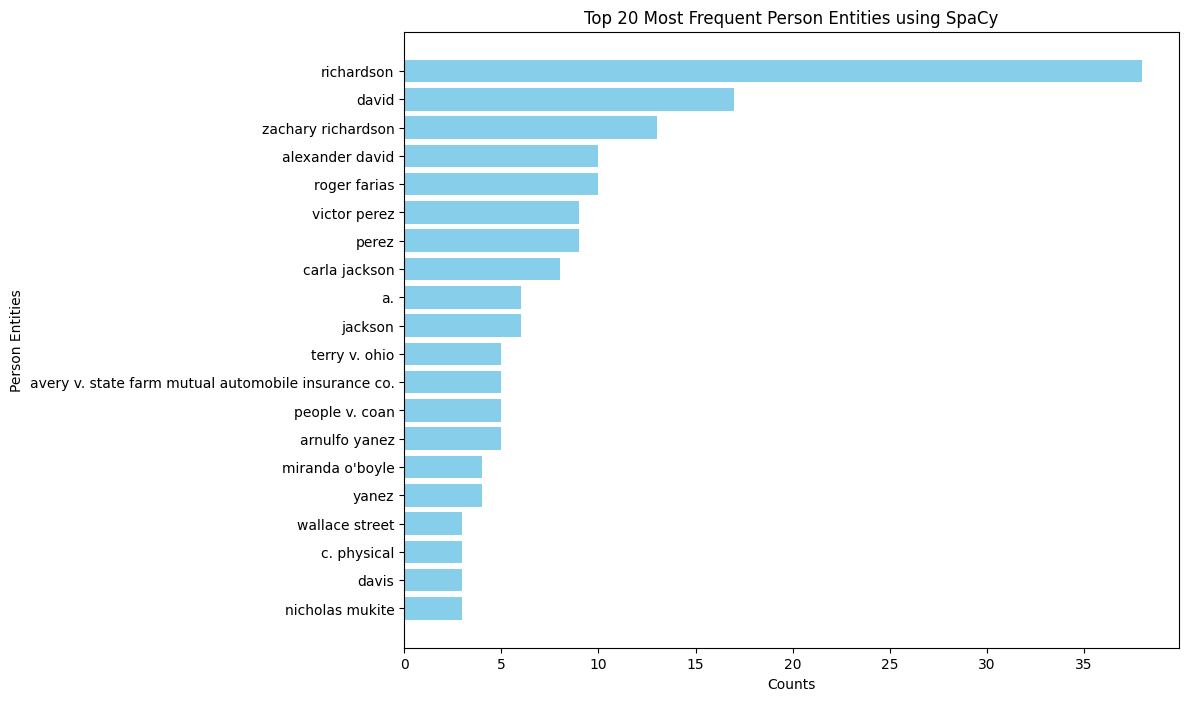

In [26]:
top_persons = sorted(all_person_counts.items(), key=lambda item: item[1], reverse=True)[:20]
names, counts = zip(*top_persons)

# Create the plot
plt.figure(figsize=(10, 8))
plt.barh(names, counts, color='skyblue')
plt.xlabel('Counts')
plt.ylabel('Person Entities')
plt.title('Top 20 Most Frequent Person Entities using SpaCy')
plt.gca().invert_yaxis()
plt.show()

Even when using lower cased words, SpaCy outperforms NLTK in correctly classifying individuals as "PERSON" for these 10 cases. Other entities that SpaCy can extract are as follows: 

In [27]:
nlp = spacy.load("en_core_web_sm")
print(nlp.get_pipe("ner").labels)

('CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART')


We can consider adding extra entities for filtration, and also using the nlp.pipe method is significantly more efficient than calling nlp on each text individually. It processes texts as a stream and yields processed Doc objects, which is especially useful for large-scale data. We are using a small sized model [en_core_web_sm](https://spacy.io/models/en#en_core_web_sm) for proecessing efficiency, but can be changed for a larger NER model if we want potentially better results.

In [39]:
def extract_entities_spacy(texts, entity_types=None, model="en_core_web_sm", batch_size=1000):
    """
    Extracts entities from a list of texts using SpaCy and counts their occurrences.

    Parameters:
    texts (list of str): The texts from which to extract entities.
    entity_types (list of str or str, optional): The types of entities to extract (e.g., 'PERSON', 'ORG'). If None, all types are extracted.
    model (str, optional): The SpaCy model to use for entity extraction. Defaults to 'en_core_web_sm'.
    batch_size (int, optional): The number of texts to process at a time. Defaults to 1000.

    Returns:
    dict: A dictionary where keys are entities and values are their counts.
    """
    nlp = spacy.load(model)
    
    if isinstance(entity_types, str):
        entity_types = [entity_types]
    
    entity_counts = {}

    for doc in nlp.pipe(texts, batch_size=batch_size):
        for ent in doc.ents:
            if entity_types is None or ent.label_ in entity_types:
                entity_counts[ent.text] = entity_counts.get(ent.text, 0) + 1

    return entity_counts

In [40]:
texts = []
for case in cases:
    case_text = text_parser.file_to_string(case)
    texts.append(case_text)

entity_types = ['PERSON', 'ORG']  # Specify desired entity types, or None to extract all types

entity_counts = extract_entities_spacy(texts, entity_types)
for entity, count in entity_counts.items():
    print(f"{entity}: {count}")

XXXX: 5
the Citgo Gas Station: 1
PPO: 10
Rank: 2
Male: 4
Rank: Probationary Police Officer: 1
Officer A: 24
PPO B: 2
Department: 42
De: 1
Illinois Traffic Pedestrian Stop Statistical Study Federal Laws 1: 1
4th Amendment, U. S. Constitution Municipal Code 1: 1
COPA: 85
Involved Individual 1: 3
Chrysler: 2
wheels.2 b.  : 1
BWC: 8
c.  : 2
The CPD Traffic Stop Statistical Study, Stop Report: 1
Audio: 1
the Mission Statement: 1
Core Values: 1
CPD: 21
Involve d Individual 1: 1
Terry v. Ohio: 5
Chapte: 1
People v. Jackson: 1
Garcia -Garcia: 1
Traffic Stop Statistical Study: 1
People v. Mott: 1
St. Christopher: 1
Unfounded Unfounded PPO B 1: 1
Unfounded Unfounded: 1
Date of Incident: 2
S. Wallace Street: 1
the Independent Police Review Authority: 4
IPRA: 26
the Chicago Police Department: 16
ALLEGATIONS Star#: 1
Assigned: 3
Asian/Pacific Islander Star#: 1
Hispanic Star#: 1
Officer: 8
Orders 1: 3
a. Interviews: 1
Detective Division: 3
IL: 4
Att: 66
Detective: 1
GPR: 1
Wallace: 10
7 / U#11 Offic

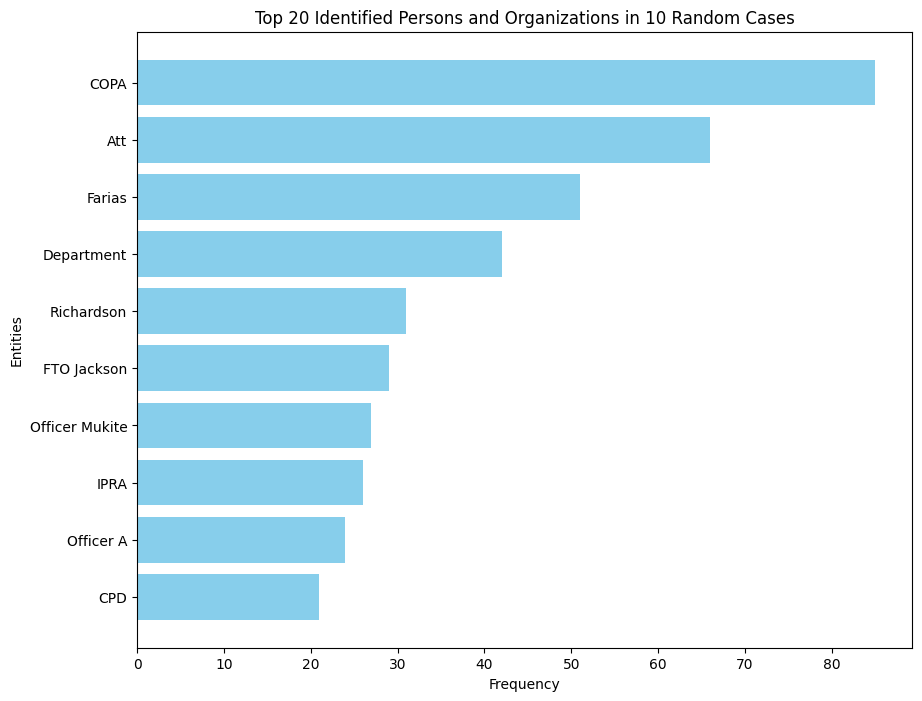

In [41]:
sorted_entity_counts = sorted(entity_counts.items(), key=lambda x: x[1], reverse=True)

top_n = sorted_entity_counts[:10]

entities, counts = zip(*top_n)  # Unzip the entity names and their counts

plt.figure(figsize=(10, 8))
plt.barh(entities, counts, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Entities')
plt.title('Top 20 Identified Persons and Organizations in 10 Random Cases')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest counts at the top
plt.show()